In [59]:
import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import soundfile as sf
import math
import scipy
import IPython.display as ipd

    
fm = matplotlib.font_manager.FontProperties()
fm.set_size(15)


def show_melspec(y=None, S=None, fp=None, size=(20,5), title="", nmels=229, n_fft=320, hop_length=160, win_length=320, window='hann'):
    if S is not None:
        y = librosa.istft(S, 
                         n_fft=n_fft, 
                         hop_length=hop_length, 
                         win_length=win_length, 
                         window=window, 
                         center=False)
    elif fp is not None:
        y, fs = librosa.load(fp, sr=None)
    else:
        assert y is not None, "either y, S or fp must be non-empty"
    fig, ax = plt.subplots(figsize=size)
    tmp_melspec = librosa.feature.melspectrogram(y=y, n_mels=nmels, power=2) # n_fft=2048, hop_length=512
    tmp_mel_dB = librosa.power_to_db(tmp_melspec, ref=np.max)
    Nimg = librosa.display.specshow(tmp_mel_dB, x_axis='time', y_axis='mel')#, sr=fs, fmax=fs//2, ax=ax)
#     fig.colorbar(Nimg, ax=ax, format='%+2.0f dB')
    ax.set_title(title, fontproperties=fm)
    plt.show()
    

def get_comb_hann_window(comb_window_len):
    assert comb_window_len % 2 == 1, "comb window should be odd length."
    comb_half_order = comb_window_len // 2
    comb_hann_window = np.zeros(comb_window_len)
    temp_sum = 0
    for i in range(1, comb_window_len+1, 1):
        comb_hann_window[i-1] = 0.5 - 0.5*math.cos(2.0 * math.pi * i / (comb_window_len+1))
        temp_sum += comb_hann_window[i-1]
    for i in range(1, comb_window_len+1, 1):
        comb_hann_window[i-1] /= temp_sum
    return comb_hann_window

    
def comb_filtering(y, f0list, comb_hann_window, PAD_F, PAD_E):
    COMB_O = len(comb_hann_window)//2
    num_frames = (len(y) - nfft)//hop_length + 1
    assert len(f0list) == num_frames
    
    y_comb_frames = np.zeros((nfft, num_frames), dtype=np.float32)
    y_pad = np.concatenate([np.zeros(PAD_F), y, np.zeros(PAD_E)], axis=-1)
    for idx, f0 in enumerate(f0list):
        for order in range(-COMB_O, COMB_O+1, 1):
            begin = PAD_F + idx * hop_length + order * f0
            end = begin + nfft
            y_comb_frames[:, idx] += y_pad[begin : end] * comb_hann_window[order+COMB_O]
    return y_comb_frames


# 将基频转为采样点数
def f0_to_samples(f0list, fs):
    f0_in_samples = []
    for f0 in f0list:
        if np.isnan(f0):
            f0_in_samples.append(0)
        elif (f0 < 80) or (f0 > 500):
            f0_in_samples.append(0)
        else:
            f0_in_samples.append(int(round(fs / f0)))
    return f0_in_samples
    

def get_spec_and_band(erbbank, y=None, S=None, n_fft=960, hop_length=480, win_length=960, window="hann", center=False):
    if y is not None:
        Y = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center)
        mag_Y = np.abs(Y)
        power_Y = mag_Y * mag_Y
        Y_erbbands = np.matmul(erbbank.T, power_Y)
        
    elif S is not None:
        assert S.shape[0] == n_fft, "S may need to be transposed"
        if isinstance(window, str):
            window = scipy.signal.get_window(window, win_length)
        elif not isinstance(window, np.ndarray):
            raise RuntimeError("invalid window param, must be a str or np.array")
            
        S_windowed = window * S.T
        Y = scipy.fft.rfft(S_windowed, axis=1).T
        power_Y = np.abs(Y)**2
        Y_erbbands = np.matmul(erbbank.T, power_Y)
    else:
        raise RuntimeError("invalid window param, either y or S must be non empty")
    return Y, Y_erbbands


def compute_band_corr(X, P):
    bands_corr = np.zeros((num_bands, X.shape[1]))
    for col in range(X.shape[1]):
        tmp_corr = np.zeros(num_bands)
        for i in range(num_bands-1):
            band_size = nfftborder[i+1] - nfftborder[i]
            for j in range(band_size):
                frac = j / band_size
                tmp = (np.conj(X[nfftborder[i] + j, col]) * P[nfftborder[i] + j, col]).real
                tmp_corr[i] += (1-frac) * tmp
                tmp_corr[i+1] += frac * tmp
#         tmp_corr[0] *= 2
#         tmp_corr[num_bands-1] *= 2
        bands_corr[:, col] = tmp_corr
    return bands_corr


def compute_r_with_author_formulae(X, Y, P, X_erbbands, Y_erbbands, P_erbbands, comb_hann_window):
    ########## q_x
    Exp = compute_band_corr(X, P)
    q_x = np.minimum(1, np.maximum(0, Exp/np.sqrt(1e-15+X_erbbands*P_erbbands)))

    ########## q_y
    Eyp = compute_band_corr(Y, P)
    q_y = np.minimum(1, np.maximum(0, Eyp/np.sqrt(1e-15+Y_erbbands*P_erbbands)))

    ########## q_phat
    sigma_square = np.sum(comb_hann_window**2)
    under_sqrt = np.maximum(0, (1-sigma_square) * q_y**2 + sigma_square)
    q_phat = q_y / np.sqrt(under_sqrt)

    ########## a, b, c
    a = q_phat**2 - q_x**2
    a = np.maximum(0, a)

    b = q_phat*q_y*(1-q_x**2)
    c = q_x**2 - q_y**2

    ########## r
    under_sqrt = np.maximum(0, b**2 + a*c)
    alpha = (np.sqrt(under_sqrt)-b)/(a+1e-15)
    r = alpha / (1 + alpha)
    r = np.minimum(1, np.maximum(0, r))

    return r, q_phat, q_x


def adjust_r_g(r, g, q_phat, q_x):
    n0 = 0.03
    for col in range(r.shape[1]):
        for i in range(num_bands):
            if q_phat[i, col] < q_x[i, col]:
                g_att = np.sqrt((1+n0-(q_x[i, col])**2)/(1+n0-(q_phat[i, col])**2))
                r[i, col] = 1
                g[i, col] *= g_att
    return r, g

MAX_F0_IN_SAMPLES = 601
PAD_F = 3005
PAD_E = 3965


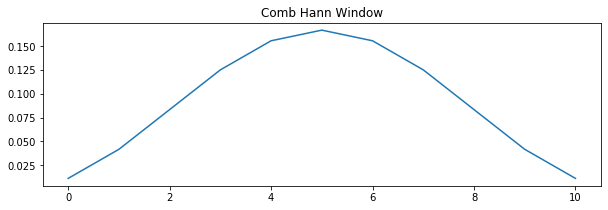

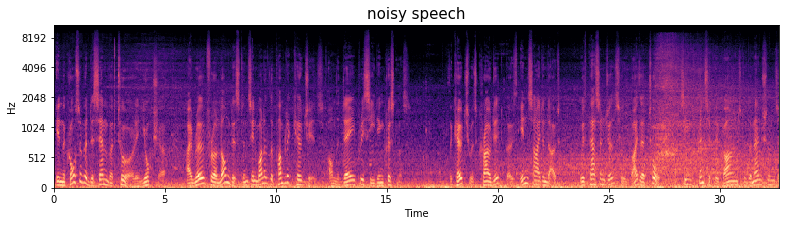

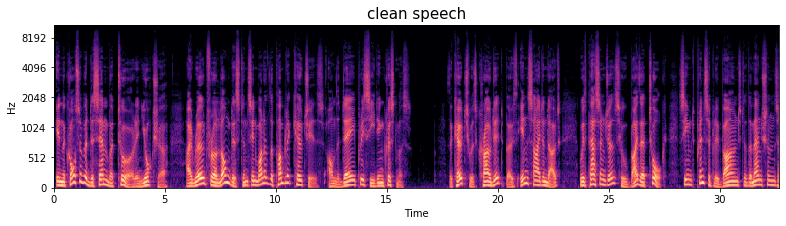

In [48]:
fs = 48000
nfft = 960
hop_length = nfft // 2
nmels = 229
num_bands = 34
nfftborder = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 
              54, 57, 65, 75, 86, 99, 115, 132, 152, 175, 201, 230, 265, 304, 349, 400]

comb_hann_window = get_comb_hann_window(11)
MIN_F0 = 80
MAX_F0 = 500
MAX_F0_IN_SAMPLES = int(fs / MIN_F0) + 1
COMB_HALF_ORDER = len(comb_hann_window)//2
PAD_F = MAX_F0_IN_SAMPLES * COMB_HALF_ORDER
PAD_E = MAX_F0_IN_SAMPLES * COMB_HALF_ORDER + nfft
print("MAX_F0_IN_SAMPLES =", MAX_F0_IN_SAMPLES)
print("PAD_F =", PAD_F)
print("PAD_E =", PAD_E)

expected_fs = 48000

noisy_file = f"./demo_files/percepnet-noisy.wav"
clean_file = f"./demo_files/percepnet-clean.wav"

y, fs = librosa.load(noisy_file, sr=expected_fs)
x, fs = librosa.load(clean_file, sr=expected_fs)
y = y[: 15*fs]
x = x[: 15*fs]


plt.figure(figsize=(10,3))
plt.plot(comb_hann_window)
plt.title("Comb Hann Window")
plt.show()

show_melspec(y=y, size=(13,3), title="noisy speech", window="hann")
show_melspec(y=x, size=(13,3), title="clean speech", window="hann")


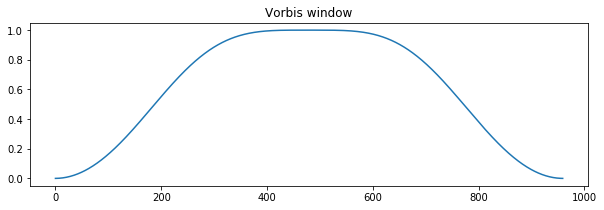

In [4]:
################## vorbis window #################
vorbis_window = np.zeros(nfft, dtype=np.float32)
for i in range(nfft//2):
    vorbis_window[i] = np.sin(0.5*np.pi*np.sin(.5*np.pi*(i+.5)/(nfft//2))**2)
    vorbis_window[nfft - i - 1] = vorbis_window[i]

plt.figure(figsize=(10,3))
plt.plot(np.arange(nfft), vorbis_window)
plt.title("Vorbis window")
plt.show()

erb_bank: (34, 481)


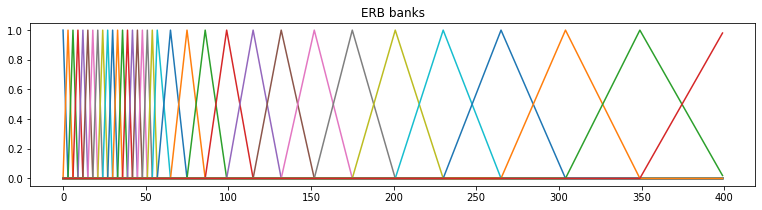

In [51]:
def get_erb_filterbank(num_freqs, num_bands, nfftborder):
    dense_filterbank = np.zeros((num_bands, num_freqs), dtype=np.float32)
    for i in range(len(nfftborder)-1):
        band_size = nfftborder[i+1] - nfftborder[i]
        for j in range(band_size):
            frac = 1.0*j/band_size
            dense_filterbank[i, nfftborder[i]+j] += 1-frac
            dense_filterbank[i+1, nfftborder[i]+j] += frac
    return dense_filterbank
  
erb_bank = get_erb_filterbank(nfft//2+1, num_bands, nfftborder)       
print("erb_bank:", erb_bank.shape)
plt.figure(figsize=(13,3))
for i in range(erb_bank.shape[0]):
    plt.plot(erb_bank[i, :400], "-")
plt.title("ERB banks")
plt.show()

erb_bank = erb_bank.T

In [53]:

Y, Y_erbbands = get_spec_and_band(erb_bank, y=y, window=vorbis_window)
X, X_erbbands = get_spec_and_band(erb_bank, y=x, window=vorbis_window)
print("Y:", Y.shape)
print("Y_erbbands:", Y_erbbands.shape)
print("X:", X.shape)
print("X_erbbands:", X_erbbands.shape)

Y: (481, 1499)
Y_erbbands: (34, 1499)
X: (481, 1499)
X_erbbands: (34, 1499)


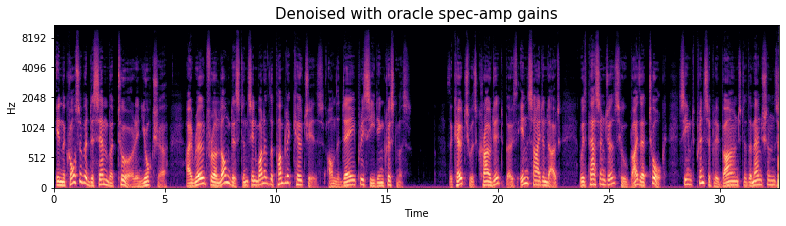

Denoised with oracle spec-amp gains


In [55]:
############ denoise using oracle amplitude spectrum gains #################
oracle_amp_gains = np.abs(X)/(1e-15+np.abs(Y))
oracle_amp_gains_denoised_Y = oracle_amp_gains * Y
oracle_amp_gains_denoised_y = librosa.istft(oracle_amp_gains_denoised_Y, 
#                                             n_fft=nfft, 
                                            hop_length=hop_length, 
                                            win_length=nfft, 
                                            window=vorbis_window, 
                                            center=False)

oracle_amp_gains_denoised_file_path = "demo_files/oracle_amp_gains_denoised.wav"
sf.write(oracle_amp_gains_denoised_file_path, oracle_amp_gains_denoised_y, fs)

show_melspec(fp=oracle_amp_gains_denoised_file_path, size=(13,3), title='Denoised with oracle spec-amp gains')
print('Denoised with oracle spec-amp gains')
ipd.Audio(filename=oracle_amp_gains_denoised_file_path)

interpolated oracle gain: (481, 1499)


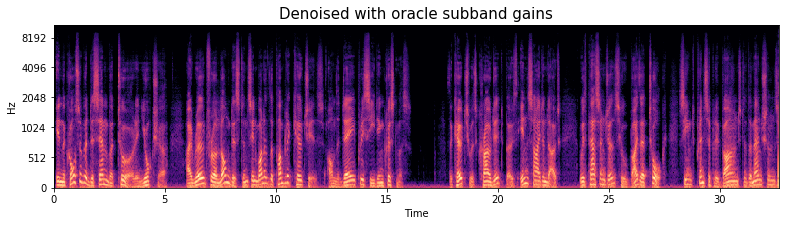

Denoised with oracle subband gains


In [58]:
############ denoise using oracle subband gains #################
oracle_subband_gains = np.sqrt(X_erbbands / (1e-15+Y_erbbands))
oracle_subband_gains = np.maximum(np.minimum(oracle_subband_gains, 1), 0)
oracle_subband_gains_interp = np.matmul(erb_bank, oracle_subband_gains)
print("interpolated oracle gain:", oracle_subband_gains_interp.shape)

oracle_subband_gains_denoised_Y = oracle_subband_gains_interp * Y
oracle_subband_gains_denoised_y = librosa.istft(oracle_subband_gains_denoised_Y, 
#                                                 n_fft=nfft, 
                                                hop_length=hop_length, 
                                                win_length=nfft, 
                                                window=vorbis_window, 
                                                center=False)

oracle_subband_gains_denoised_file_path = "demo_files/oracle_subband_gains_denoised.wav"
sf.write(oracle_subband_gains_denoised_file_path, oracle_subband_gains_denoised_y, fs)

show_melspec(fp=oracle_subband_gains_denoised_file_path, size=(13,3), title='Denoised with oracle subband gains')
print('Denoised with oracle subband gains')
ipd.Audio(filename=oracle_subband_gains_denoised_file_path)

ycomb_frames (960, 1499)
xcomb_frames (960, 1499)


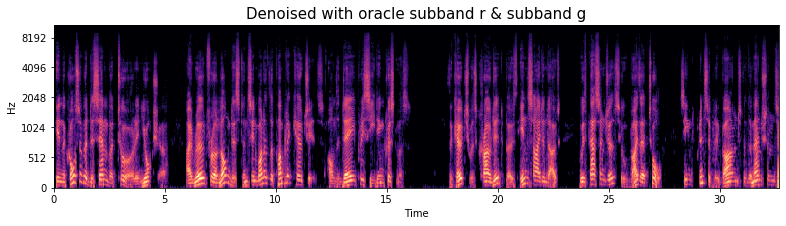

Denoised with oracle subband r & g


In [75]:
############ denoise using pitch-filtering & oracle subband gains #################

npz = np.load("demo_files/f0results.npz")
f0x = npz['f0clean'] 
f0y = npz['f0noisy']
f0x = f0x[: Y.shape[1]]
f0y = f0y[: Y.shape[1]]

f0y_in_samples = f0_to_samples(f0y, fs)
f0x_in_samples = f0_to_samples(f0x, fs)

ycomb_frames = comb_filtering(y, f0x_in_samples, comb_hann_window, PAD_F, PAD_E)
xcomb_frames = comb_filtering(x, f0x_in_samples, comb_hann_window, PAD_F, PAD_E)
print("ycomb_frames", ycomb_frames.shape)
print("xcomb_frames", xcomb_frames.shape)

P_hat, P_hat_erbbands = get_spec_and_band(erb_bank, S=ycomb_frames, window=vorbis_window)
P, P_erbbands         = get_spec_and_band(erb_bank, S=xcomb_frames, window=vorbis_window)

######################## compute the oracle r with author formulae ##########################
subband_r, q_phat, q_x = compute_r_with_author_formulae(X, Y, P, X_erbbands, Y_erbbands, P_erbbands, comb_hann_window)
subband_r, subband_g = adjust_r_g(subband_r, oracle_subband_gains, q_phat, q_x)
    
oracle_subband_r_extrapolate = np.matmul(erb_bank, subband_r)
oracle_subband_g_extrapolate = np.matmul(erb_bank, oracle_subband_gains)

oracle_subband_r_inv_extrapolate = 1 - oracle_subband_r_extrapolate

Z = Y * oracle_subband_r_inv_extrapolate + P_hat * oracle_subband_r_extrapolate

oracle_subband_r_and_g_denoised_Y = oracle_subband_g_extrapolate * Z

oracle_subband_r_and_g_denoised_y = librosa.istft(oracle_subband_r_and_g_denoised_Y, 
#                                                      n_fft=nfft, 
                                                  hop_length=hop_length, 
                                                  win_length=nfft, 
                                                  window=vorbis_window, 
                                                  center=False)

oracle_subband_r_and_g_denoised_file_path = "demo_files/oracle_subband_r_and_g_denoised.wav"
sf.write(oracle_subband_r_and_g_denoised_file_path, oracle_subband_r_and_g_denoised_y, fs)

show_melspec(fp=oracle_subband_r_and_g_denoised_file_path, size=(13,3), title="Denoised with oracle subband r & subband g", window=vorbis_window)
print('Denoised with oracle subband r & g')
ipd.Audio(filename=oracle_subband_r_and_g_denoised_file_path)

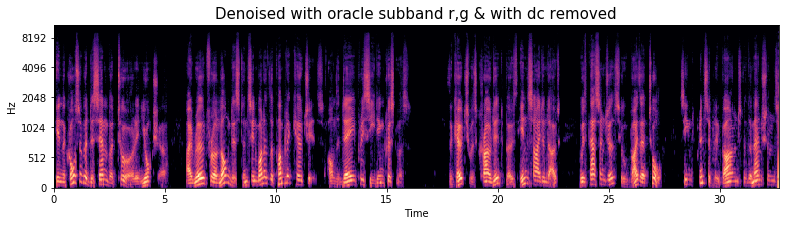

Denoised with oracle subband r,g & with dc removed


In [77]:
def filter_dc_notch16(memNotch, in_audio, radius):
    frame_size = in_audio.shape[0]

    den2 = radius * radius + 0.7 * (1 - radius) * (1 - radius)
    for i in range(frame_size):
        vin = in_audio[i]
        vout = memNotch[0] + vin
        memNotch[0] = memNotch[1] + 2 * (-vin + radius * vout)
        memNotch[1] = vin - den2 * vout
        in_audio[i] = radius * vout

notch_mem = np.zeros([2], dtype=np.float64)

filter_dc_notch16(notch_mem, oracle_subband_r_and_g_denoised_y, 0.986)

dc_notched_file_path = "demo_files/oracle_subband_r_and_g_denoised_remove_dc.wav"
sf.write(dc_notched_file_path, oracle_subband_r_and_g_denoised_y, fs)

show_melspec(fp=dc_notched_file_path, size=(13,3), title="Denoised with oracle subband r,g & with dc removed", window=vorbis_window)
print('Denoised with oracle subband r,g & with dc removed')
ipd.Audio(filename=dc_notched_file_path)